In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten, Dropout, MaxPooling2D
from keras.optimizers import SGD
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report,roc_curve, roc_auc_score,auc

Using TensorFlow backend.


## Neural Network

### 1.数据集加载

In [2]:
data = pd.read_csv('./dataset/creditcard.csv')

# 将Amount标准化，并将不需要用到的Time去掉
data[['Amount']] = StandardScaler().fit_transform(data[['Amount']])
data=data.loc[:,data.columns!='Time']

# 分离特征和标签
X = data.loc[:, data.columns != 'Class']
y = data['Class']

### 2.训练集、测试集划分

In [3]:
X_train, X_test, y_train, y_test = \
                   train_test_split(X,y,test_size = 0.3, 
                                    random_state = 0)

### 3. 模型
#### 3.1 下采样

In [4]:
# 计算少数类个数
number_records_fraud = len(data[data.Class == 1])
# 取得少数类样本的索引
fraud_indices = np.array(data[data.Class == 1].index)
# 取得多数类样本的索引
normal_indices = data[data.Class == 0].index

# 从多数类中随机选择与少数类个数相同的样本数作为样本
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# 合并随机取得的0类和全部的1类的索引
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# 根据索引得到下采样后的数据集
under_sample_data = data.iloc[under_sample_indices,:]

# 分离特征和标签
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

print("正样本比例(0类): ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("负样本比例(1类): ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("下采样后总样本个数为: ", len(under_sample_data))

正样本比例(0类):  0.5
负样本比例(1类):  0.5
下采样后总样本个数为:  984


In [5]:
# 下采样
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = \
                                                train_test_split(X_undersample,
                                                                 y_undersample,
                                                                 test_size = 0.3,
                                                                 random_state = 0)

In [6]:
model = Sequential()
model.add(Dense(29, input_dim=29, activation='relu'))     # kernel_initializer='normal'
model.add(Dense(15, input_dim=29, activation='relu'))
model.add(Dense(1, activation='sigmoid'))                 # kernel_initializer='normal'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

W0609 15:54:00.100049  2328 deprecation.py:323] From E:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                450       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 1,336
Trainable params: 1,336
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(X_train_undersample.as_matrix(),y_train_undersample.values.ravel(),epochs=1000)
y_pred_undersample = model.predict(X_test.as_matrix()).astype(int)
y_test_undersample=np.array(y_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)

print(classification_report(y_test_undersample,y_pred_undersample))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_undersample,y_pred_undersample)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
W0609 15:54:00.592730  2328 deprecation_wrapper.py:119] From E:\Anaconda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/1000
688/688 [==============================] - 0s 269us/step - loss: 0.7428 - accuracy: 0.6061
Epoch 2/1000
688/688 [==============================] - 0s 54us/step - loss: 0.4074 - accuracy: 0.8474
Epoch 3/1000
688/688 [==============================] - 0s 37us/step - loss: 0.3328 - accuracy: 0.8968
Epoch 4/1000
688/688 [==============================] - 0s 38us/step - loss: 0.2817 - accuracy: 0.9186
Epoch 5/1000
688/688 [==============================] - 0s 36us/step - loss: 0.2447 - accuracy: 0.9259
Epoch 6/1000
688/688 [==============================] - 0s 39us/step - loss: 0.2172 - accuracy: 0.9259
Epoch 7/1000
688/688 [==============================] - 0s 41us/step - loss: 0.1961 - accuracy: 0.9317
Epoch 8/1000
688/688 [==============================] - 0s 39us/step - loss: 0.1791 - accuracy: 0.9346
Epoch 9/1000
688/688 [==============================] - 0s 38us/step - loss: 0.1648 - accuracy: 0.9390
Epoch 10/1000
688/688 [==============================] - 0s 39us/step - 

688/688 [==============================] - 0s 42us/step - loss: 0.0164 - accuracy: 0.9985
Epoch 80/1000
688/688 [==============================] - 0s 25us/step - loss: 0.0157 - accuracy: 0.9985
Epoch 81/1000
688/688 [==============================] - 0s 49us/step - loss: 0.0151 - accuracy: 0.9985
Epoch 82/1000
688/688 [==============================] - 0s 17us/step - loss: 0.0146 - accuracy: 0.9985
Epoch 83/1000
688/688 [==============================] - 0s 58us/step - loss: 0.0144 - accuracy: 0.9985
Epoch 84/1000
688/688 [==============================] - 0s 41us/step - loss: 0.0141 - accuracy: 0.9985
Epoch 85/1000
688/688 [==============================] - 0s 35us/step - loss: 0.0133 - accuracy: 0.9985
Epoch 86/1000
688/688 [==============================] - 0s 23us/step - loss: 0.0127 - accuracy: 0.9985
Epoch 87/1000
688/688 [==============================] - 0s 45us/step - loss: 0.0123 - accuracy: 1.0000
Epoch 88/1000
688/688 [==============================] - 0s 53us/step - loss: 

688/688 [==============================] - 0s 38us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 157/1000
688/688 [==============================] - 0s 33us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 158/1000
688/688 [==============================] - 0s 29us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 159/1000
688/688 [==============================] - 0s 23us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 160/1000
688/688 [==============================] - 0s 23us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 161/1000
688/688 [==============================] - 0s 48us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 162/1000
688/688 [==============================] - 0s 37us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 163/1000
688/688 [==============================] - 0s 33us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 164/1000
688/688 [==============================] - 0s 23us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 165/1000
688/688 [==============================] - 0s 45us/step

688/688 [==============================] - 0s 88us/step - loss: 3.3810e-04 - accuracy: 1.0000
Epoch 232/1000
688/688 [==============================] - 0s 93us/step - loss: 3.2734e-04 - accuracy: 1.0000
Epoch 233/1000
688/688 [==============================] - 0s 74us/step - loss: 3.2194e-04 - accuracy: 1.0000
Epoch 234/1000
688/688 [==============================] - 0s 64us/step - loss: 3.1656e-04 - accuracy: 1.0000
Epoch 235/1000
688/688 [==============================] - 0s 61us/step - loss: 3.0870e-04 - accuracy: 1.0000
Epoch 236/1000
688/688 [==============================] - 0s 50us/step - loss: 3.0621e-04 - accuracy: 1.0000
Epoch 237/1000
688/688 [==============================] - 0s 32us/step - loss: 3.0798e-04 - accuracy: 1.0000
Epoch 238/1000
688/688 [==============================] - 0s 47us/step - loss: 3.1934e-04 - accuracy: 1.0000
Epoch 239/1000
688/688 [==============================] - 0s 39us/step - loss: 3.0006e-04 - accuracy: 1.0000
Epoch 240/1000
688/688 [==========

688/688 [==============================] - 0s 45us/step - loss: 9.5839e-05 - accuracy: 1.0000
Epoch 307/1000
688/688 [==============================] - 0s 23us/step - loss: 9.8491e-05 - accuracy: 1.0000
Epoch 308/1000
688/688 [==============================] - 0s 47us/step - loss: 9.5644e-05 - accuracy: 1.0000
Epoch 309/1000
688/688 [==============================] - 0s 52us/step - loss: 9.5792e-05 - accuracy: 1.0000
Epoch 310/1000
688/688 [==============================] - 0s 17us/step - loss: 9.0595e-05 - accuracy: 1.0000
Epoch 311/1000
688/688 [==============================] - 0s 45us/step - loss: 9.0243e-05 - accuracy: 1.0000
Epoch 312/1000
688/688 [==============================] - 0s 45us/step - loss: 8.7845e-05 - accuracy: 1.0000
Epoch 313/1000
688/688 [==============================] - 0s 23us/step - loss: 8.5409e-05 - accuracy: 1.0000
Epoch 314/1000
688/688 [==============================] - 0s 23us/step - loss: 8.8093e-05 - accuracy: 1.0000
Epoch 315/1000
688/688 [==========

688/688 [==============================] - 0s 32us/step - loss: 3.1651e-05 - accuracy: 1.0000
Epoch 382/1000
688/688 [==============================] - 0s 23us/step - loss: 3.1002e-05 - accuracy: 1.0000
Epoch 383/1000
688/688 [==============================] - 0s 57us/step - loss: 3.0894e-05 - accuracy: 1.0000
Epoch 384/1000
688/688 [==============================] - 0s 49us/step - loss: 3.0328e-05 - accuracy: 1.0000
Epoch 385/1000
688/688 [==============================] - 0s 36us/step - loss: 2.9880e-05 - accuracy: 1.0000
Epoch 386/1000
688/688 [==============================] - 0s 43us/step - loss: 2.9569e-05 - accuracy: 1.0000
Epoch 387/1000
688/688 [==============================] - 0s 25us/step - loss: 2.9296e-05 - accuracy: 1.0000
Epoch 388/1000
688/688 [==============================] - 0s 45us/step - loss: 2.8627e-05 - accuracy: 1.0000
Epoch 389/1000
688/688 [==============================] - 0s 39us/step - loss: 2.8793e-05 - accuracy: 1.0000
Epoch 390/1000
688/688 [==========

688/688 [==============================] - 0s 41us/step - loss: 1.1573e-05 - accuracy: 1.0000
Epoch 457/1000
688/688 [==============================] - 0s 39us/step - loss: 1.0931e-05 - accuracy: 1.0000
Epoch 458/1000
688/688 [==============================] - 0s 36us/step - loss: 1.1003e-05 - accuracy: 1.0000
Epoch 459/1000
688/688 [==============================] - 0s 19us/step - loss: 1.1002e-05 - accuracy: 1.0000
Epoch 460/1000
688/688 [==============================] - 0s 45us/step - loss: 1.0864e-05 - accuracy: 1.0000
Epoch 461/1000
688/688 [==============================] - 0s 23us/step - loss: 1.0530e-05 - accuracy: 1.0000
Epoch 462/1000
688/688 [==============================] - 0s 45us/step - loss: 1.0193e-05 - accuracy: 1.0000
Epoch 463/1000
688/688 [==============================] - 0s 23us/step - loss: 1.0139e-05 - accuracy: 1.0000
Epoch 464/1000
688/688 [==============================] - 0s 63us/step - loss: 1.0323e-05 - accuracy: 1.0000
Epoch 465/1000
688/688 [==========

688/688 [==============================] - 0s 23us/step - loss: 4.1317e-06 - accuracy: 1.0000
Epoch 531/1000
688/688 [==============================] - 0s 45us/step - loss: 4.0861e-06 - accuracy: 1.0000
Epoch 532/1000
688/688 [==============================] - 0s 23us/step - loss: 4.0635e-06 - accuracy: 1.0000
Epoch 533/1000
688/688 [==============================] - 0s 53us/step - loss: 3.9323e-06 - accuracy: 1.0000
Epoch 534/1000
688/688 [==============================] - 0s 42us/step - loss: 3.9170e-06 - accuracy: 1.0000
Epoch 535/1000
688/688 [==============================] - 0s 14us/step - loss: 3.8679e-06 - accuracy: 1.0000
Epoch 536/1000
688/688 [==============================] - 0s 23us/step - loss: 3.7948e-06 - accuracy: 1.0000
Epoch 537/1000
688/688 [==============================] - 0s 45us/step - loss: 3.7913e-06 - accuracy: 1.0000
Epoch 538/1000
688/688 [==============================] - 0s 23us/step - loss: 3.7471e-06 - accuracy: 1.0000
Epoch 539/1000
688/688 [==========

688/688 [==============================] - 0s 45us/step - loss: 1.5231e-06 - accuracy: 1.0000
Epoch 606/1000
688/688 [==============================] - 0s 32us/step - loss: 1.5078e-06 - accuracy: 1.0000
Epoch 607/1000
688/688 [==============================] - 0s 45us/step - loss: 1.4885e-06 - accuracy: 1.0000
Epoch 608/1000
688/688 [==============================] - 0s 37us/step - loss: 1.4770e-06 - accuracy: 1.0000
Epoch 609/1000
688/688 [==============================] - 0s 43us/step - loss: 1.4499e-06 - accuracy: 1.0000
Epoch 610/1000
688/688 [==============================] - 0s 36us/step - loss: 1.4313e-06 - accuracy: 1.0000
Epoch 611/1000
688/688 [==============================] - 0s 48us/step - loss: 1.4126e-06 - accuracy: 1.0000
Epoch 612/1000
688/688 [==============================] - 0s 38us/step - loss: 1.4078e-06 - accuracy: 1.0000
Epoch 613/1000
688/688 [==============================] - 0s 39us/step - loss: 1.3742e-06 - accuracy: 1.0000
Epoch 614/1000
688/688 [==========

688/688 [==============================] - 0s 48us/step - loss: 5.9653e-07 - accuracy: 1.0000
Epoch 681/1000
688/688 [==============================] - 0s 45us/step - loss: 5.8411e-07 - accuracy: 1.0000
Epoch 682/1000
688/688 [==============================] - 0s 23us/step - loss: 5.6875e-07 - accuracy: 1.0000
Epoch 683/1000
688/688 [==============================] - 0s 23us/step - loss: 5.6398e-07 - accuracy: 1.0000
Epoch 684/1000
688/688 [==============================] - 0s 61us/step - loss: 5.6029e-07 - accuracy: 1.0000
Epoch 685/1000
688/688 [==============================] - 0s 48us/step - loss: 5.4721e-07 - accuracy: 1.0000
Epoch 686/1000
688/688 [==============================] - 0s 42us/step - loss: 5.6071e-07 - accuracy: 1.0000
Epoch 687/1000
688/688 [==============================] - 0s 36us/step - loss: 5.4248e-07 - accuracy: 1.0000
Epoch 688/1000
688/688 [==============================] - 0s 15us/step - loss: 5.3926e-07 - accuracy: 1.0000
Epoch 689/1000
688/688 [==========

688/688 [==============================] - 0s 57us/step - loss: 2.2852e-07 - accuracy: 1.0000
Epoch 756/1000
688/688 [==============================] - 0s 55us/step - loss: 2.2718e-07 - accuracy: 1.0000
Epoch 757/1000
688/688 [==============================] - 0s 48us/step - loss: 2.2356e-07 - accuracy: 1.0000
Epoch 758/1000
688/688 [==============================] - 0s 45us/step - loss: 2.2110e-07 - accuracy: 1.0000
Epoch 759/1000
688/688 [==============================] - 0s 45us/step - loss: 2.1766e-07 - accuracy: 1.0000
Epoch 760/1000
688/688 [==============================] - 0s 55us/step - loss: 2.1471e-07 - accuracy: 1.0000
Epoch 761/1000
688/688 [==============================] - 0s 45us/step - loss: 2.1292e-07 - accuracy: 1.0000
Epoch 762/1000
688/688 [==============================] - 0s 70us/step - loss: 2.1385e-07 - accuracy: 1.0000
Epoch 763/1000
688/688 [==============================] - 0s 54us/step - loss: 2.0884e-07 - accuracy: 1.0000
Epoch 764/1000
688/688 [==========

688/688 [==============================] - 0s 48us/step - loss: 9.1568e-08 - accuracy: 1.0000
Epoch 831/1000
688/688 [==============================] - 0s 43us/step - loss: 9.0677e-08 - accuracy: 1.0000
Epoch 832/1000
688/688 [==============================] - 0s 42us/step - loss: 8.9545e-08 - accuracy: 1.0000
Epoch 833/1000
688/688 [==============================] - 0s 48us/step - loss: 8.8826e-08 - accuracy: 1.0000
Epoch 834/1000
688/688 [==============================] - 0s 41us/step - loss: 8.7455e-08 - accuracy: 1.0000
Epoch 835/1000
688/688 [==============================] - 0s 38us/step - loss: 8.6116e-08 - accuracy: 1.0000
Epoch 836/1000
688/688 [==============================] - 0s 35us/step - loss: 8.5206e-08 - accuracy: 1.0000
Epoch 837/1000
688/688 [==============================] - 0s 38us/step - loss: 8.4901e-08 - accuracy: 1.0000
Epoch 838/1000
688/688 [==============================] - 0s 45us/step - loss: 8.3005e-08 - accuracy: 1.0000
Epoch 839/1000
688/688 [==========

688/688 [==============================] - 0s 61us/step - loss: 3.7894e-08 - accuracy: 1.0000
Epoch 906/1000
688/688 [==============================] - 0s 45us/step - loss: 3.7443e-08 - accuracy: 1.0000
Epoch 907/1000
688/688 [==============================] - 0s 48us/step - loss: 3.7231e-08 - accuracy: 1.0000
Epoch 908/1000
688/688 [==============================] - 0s 39us/step - loss: 3.6530e-08 - accuracy: 1.0000
Epoch 909/1000
688/688 [==============================] - 0s 36us/step - loss: 3.6007e-08 - accuracy: 1.0000
Epoch 910/1000
688/688 [==============================] - 0s 36us/step - loss: 3.5822e-08 - accuracy: 1.0000
Epoch 911/1000
688/688 [==============================] - 0s 39us/step - loss: 3.5335e-08 - accuracy: 1.0000
Epoch 912/1000
688/688 [==============================] - 0s 35us/step - loss: 3.5817e-08 - accuracy: 1.0000
Epoch 913/1000
688/688 [==============================] - 0s 33us/step - loss: 3.4497e-08 - accuracy: 1.0000
Epoch 914/1000
688/688 [==========

688/688 [==============================] - 0s 42us/step - loss: 1.6714e-08 - accuracy: 1.0000
Epoch 980/1000
688/688 [==============================] - 0s 35us/step - loss: 1.6267e-08 - accuracy: 1.0000
Epoch 981/1000
688/688 [==============================] - 0s 43us/step - loss: 1.6298e-08 - accuracy: 1.0000
Epoch 982/1000
688/688 [==============================] - 0s 35us/step - loss: 1.5763e-08 - accuracy: 1.0000
Epoch 983/1000
688/688 [==============================] - 0s 38us/step - loss: 1.6102e-08 - accuracy: 1.0000
Epoch 984/1000
688/688 [==============================] - 0s 39us/step - loss: 1.5868e-08 - accuracy: 1.0000
Epoch 985/1000
688/688 [==============================] - 0s 52us/step - loss: 1.5517e-08 - accuracy: 1.0000
Epoch 986/1000
688/688 [==============================] - 0s 59us/step - loss: 1.5413e-08 - accuracy: 1.0000
Epoch 987/1000
688/688 [==============================] - 0s 61us/step - loss: 1.5299e-08 - accuracy: 1.0000
Epoch 988/1000
688/688 [==========

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


混淆矩阵： [[84127  1169]
 [   15   132]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85296
           1       0.10      0.90      0.18       147

    accuracy                           0.99     85443
   macro avg       0.55      0.94      0.59     85443
weighted avg       1.00      0.99      0.99     85443

测试集Recall:  0.8979591836734694
AUC值： 0.9421269844460013


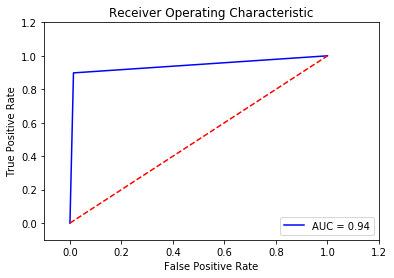

In [8]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/NN_subsample.png',bbox_inches="tight")

#### 3.2 上采样

In [9]:
model2 = Sequential()
model2.add(Dense(29, input_dim=29, activation='relu'))     # kernel_initializer='normal'
model2.add(Dense(15, input_dim=29, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))                 # kernel_initializer='normal'
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                450       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 1,336
Trainable params: 1,336
Non-trainable params: 0
_________________________________________________________________


In [10]:
from imblearn.over_sampling import SMOTE
X_train_oversample, y_train_oversample = SMOTE().fit_sample(X_train, y_train)
model2.fit(X_train_oversample.as_matrix(),y_train_oversample.values.ravel(),epochs=1000)
y_pred_oversample = model2.predict(X_test.as_matrix()).astype(int)
y_test=np.array(y_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_oversample)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)

print(classification_report(y_test,y_pred_oversample))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred_oversample)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/1000
398038/398038 [==============================] - 15s 37us/step - loss: 0.0282 - accuracy: 0.9906
Epoch 2/1000
398038/398038 [==============================] - 16s 41us/step - loss: 0.0057 - accuracy: 0.9988
Epoch 3/1000
398038/398038 [==============================] - 15s 39us/step - loss: 0.0042 - accuracy: 0.9991
Epoch 4/1000
398038/398038 [==============================] - 15s 37us/step - loss: 0.0033 - accuracy: 0.9993
Epoch 5/1000
398038/398038 [==============================] - 17s 42us/step - loss: 0.0030 - accuracy: 0.9994
Epoch 6/1000
398038/398038 [==============================] - 16s 41us/step - loss: 0.0025 - accuracy: 0.9995
Epoch 7/1000
398038/398038 [==============================] - 15s 39us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 8/1000
398038/398038 [==============================] - 17s 43us/step - loss: 0.0021 - accuracy: 0.9996
Epoch 9/1000
398038/398038 [==============================] - 17s 42us/step - loss: 0.0019 - accuracy: 0.9996
Epoch 10/1

398038/398038 [==============================] - 36s 89us/step - loss: 5.6500e-04 - accuracy: 0.9999
Epoch 72/1000
398038/398038 [==============================] - 18s 44us/step - loss: 4.0747e-04 - accuracy: 0.9999
Epoch 73/1000
398038/398038 [==============================] - 15s 38us/step - loss: 4.0806e-04 - accuracy: 0.9999
Epoch 74/1000
398038/398038 [==============================] - 17s 43us/step - loss: 4.1160e-04 - accuracy: 0.9999
Epoch 75/1000
398038/398038 [==============================] - 14s 35us/step - loss: 3.6881e-04 - accuracy: 0.9999
Epoch 76/1000
398038/398038 [==============================] - 23s 57us/step - loss: 3.4738e-04 - accuracy: 0.9999
Epoch 77/1000
398038/398038 [==============================] - 15s 37us/step - loss: 3.8037e-04 - accuracy: 0.9999
Epoch 78/1000
398038/398038 [==============================] - 14s 34us/step - loss: 3.4229e-04 - accuracy: 0.9999
Epoch 79/1000
398038/398038 [==============================] - 15s 38us/step - loss: 5.4738e-0

398038/398038 [==============================] - 13s 33us/step - loss: 3.4096e-04 - accuracy: 0.9999
Epoch 142/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.3367e-04 - accuracy: 0.9999
Epoch 143/1000
398038/398038 [==============================] - 13s 33us/step - loss: 3.7532e-04 - accuracy: 0.9999
Epoch 144/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.7981e-04 - accuracy: 0.9999
Epoch 145/1000
398038/398038 [==============================] - 13s 32us/step - loss: 2.7192e-04 - accuracy: 0.99990s - loss: 2.5882e-0
Epoch 146/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.3523e-04 - accuracy: 1.0000
Epoch 147/1000
398038/398038 [==============================] - 13s 34us/step - loss: 2.6522e-04 - accuracy: 0.9999
Epoch 148/1000
398038/398038 [==============================] - 14s 34us/step - loss: 2.7193e-04 - accuracy: 0.9999
Epoch 149/1000
398038/398038 [==============================] - 13s

398038/398038 [==============================] - 13s 34us/step - loss: 1.9476e-04 - accuracy: 0.9999
Epoch 212/1000
398038/398038 [==============================] - 13s 33us/step - loss: 3.1136e-04 - accuracy: 0.9999
Epoch 213/1000
398038/398038 [==============================] - 13s 33us/step - loss: 3.7823e-04 - accuracy: 0.9999
Epoch 214/1000
398038/398038 [==============================] - 13s 32us/step - loss: 2.6381e-04 - accuracy: 0.9999
Epoch 215/1000
398038/398038 [==============================] - 13s 33us/step - loss: 5.1008e-04 - accuracy: 0.9999
Epoch 216/1000
398038/398038 [==============================] - 13s 34us/step - loss: 3.1069e-04 - accuracy: 0.9999
Epoch 217/1000
398038/398038 [==============================] - 13s 33us/step - loss: 4.2753e-04 - accuracy: 0.9999
Epoch 218/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.7265e-04 - accuracy: 0.9999
Epoch 219/1000
398038/398038 [==============================] - 13s 34us/step - loss: 2

398038/398038 [==============================] - 13s 32us/step - loss: 4.2361e-04 - accuracy: 0.9999
Epoch 282/1000
398038/398038 [==============================] - 13s 34us/step - loss: 1.7589e-04 - accuracy: 1.0000
Epoch 283/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.9933e-04 - accuracy: 0.9999
Epoch 284/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.4331e-04 - accuracy: 0.9999
Epoch 285/1000
398038/398038 [==============================] - 13s 33us/step - loss: 3.0001e-04 - accuracy: 0.9999
Epoch 286/1000
398038/398038 [==============================] - 13s 32us/step - loss: 2.5258e-04 - accuracy: 1.0000
Epoch 287/1000
398038/398038 [==============================] - 13s 34us/step - loss: 1.6896e-04 - accuracy: 0.9999
Epoch 288/1000
398038/398038 [==============================] - 15s 38us/step - loss: 3.3308e-04 - accuracy: 0.9999
Epoch 289/1000
398038/398038 [==============================] - 16s 40us/step - loss: 1

398038/398038 [==============================] - 13s 33us/step - loss: 2.3176e-04 - accuracy: 0.9999
Epoch 352/1000
398038/398038 [==============================] - 13s 33us/step - loss: 3.7368e-04 - accuracy: 0.9999
Epoch 353/1000
398038/398038 [==============================] - 14s 35us/step - loss: 2.5001e-04 - accuracy: 0.9999
Epoch 354/1000
398038/398038 [==============================] - 13s 33us/step - loss: 1.2082e-04 - accuracy: 1.0000
Epoch 355/1000
398038/398038 [==============================] - 13s 33us/step - loss: 4.3784e-04 - accuracy: 0.9999
Epoch 356/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.4791e-04 - accuracy: 1.0000
Epoch 357/1000
398038/398038 [==============================] - 13s 33us/step - loss: 2.3983e-04 - accuracy: 1.0000
Epoch 358/1000
398038/398038 [==============================] - 13s 34us/step - loss: 3.6734e-04 - accuracy: 0.9999
Epoch 359/1000
398038/398038 [==============================] - 13s 32us/step - loss: 1

398038/398038 [==============================] - 14s 35us/step - loss: 2.6284e-04 - accuracy: 1.0000
Epoch 422/1000
398038/398038 [==============================] - 13s 34us/step - loss: 3.0721e-04 - accuracy: 1.0000
Epoch 423/1000
398038/398038 [==============================] - 14s 35us/step - loss: 2.1252e-04 - accuracy: 1.0000
Epoch 424/1000
398038/398038 [==============================] - 14s 36us/step - loss: 2.6019e-04 - accuracy: 1.0000
Epoch 425/1000
398038/398038 [==============================] - 15s 37us/step - loss: 2.0941e-04 - accuracy: 0.9999
Epoch 426/1000
398038/398038 [==============================] - 13s 34us/step - loss: 3.1779e-04 - accuracy: 0.9999
Epoch 427/1000
398038/398038 [==============================] - 13s 34us/step - loss: 2.9729e-04 - accuracy: 1.0000
Epoch 428/1000
398038/398038 [==============================] - 20s 49us/step - loss: 2.3725e-04 - accuracy: 1.0000
Epoch 429/1000
398038/398038 [==============================] - 24s 59us/step - loss: 1

398038/398038 [==============================] - 14s 36us/step - loss: 2.3712e-04 - accuracy: 0.9999
Epoch 492/1000
398038/398038 [==============================] - 14s 35us/step - loss: 2.0180e-04 - accuracy: 0.9999
Epoch 493/1000
398038/398038 [==============================] - 14s 36us/step - loss: 2.4750e-04 - accuracy: 0.9999
Epoch 494/1000
398038/398038 [==============================] - 14s 36us/step - loss: 2.0239e-04 - accuracy: 1.0000
Epoch 495/1000
398038/398038 [==============================] - 14s 34us/step - loss: 2.0072e-04 - accuracy: 1.0000
Epoch 496/1000
398038/398038 [==============================] - 14s 35us/step - loss: 1.5305e-04 - accuracy: 1.0000
Epoch 497/1000
398038/398038 [==============================] - 14s 36us/step - loss: 1.5111e-04 - accuracy: 1.0000
Epoch 498/1000
398038/398038 [==============================] - 14s 35us/step - loss: 1.9579e-04 - accuracy: 1.0000
Epoch 499/1000
398038/398038 [==============================] - 15s 37us/step - loss: 1

398038/398038 [==============================] - 14s 36us/step - loss: 1.8918e-04 - accuracy: 1.0000
Epoch 562/1000
398038/398038 [==============================] - 14s 36us/step - loss: 1.7607e-04 - accuracy: 1.0000
Epoch 563/1000
398038/398038 [==============================] - 14s 36us/step - loss: 1.8310e-04 - accuracy: 1.0000
Epoch 564/1000
398038/398038 [==============================] - 14s 35us/step - loss: 2.3697e-04 - accuracy: 1.0000
Epoch 565/1000
398038/398038 [==============================] - 14s 36us/step - loss: 3.3135e-04 - accuracy: 0.9999
Epoch 566/1000
398038/398038 [==============================] - 14s 35us/step - loss: 2.0887e-04 - accuracy: 0.9999
Epoch 567/1000
398038/398038 [==============================] - 14s 36us/step - loss: 1.8988e-04 - accuracy: 1.0000
Epoch 568/1000
398038/398038 [==============================] - 13s 34us/step - loss: 3.3803e-04 - accuracy: 0.9999
Epoch 569/1000
398038/398038 [==============================] - 14s 36us/step - loss: 1

398038/398038 [==============================] - 22s 54us/step - loss: 2.3251e-04 - accuracy: 0.9999
Epoch 632/1000
398038/398038 [==============================] - 15s 38us/step - loss: 1.5431e-04 - accuracy: 1.0000
Epoch 633/1000
398038/398038 [==============================] - 19s 48us/step - loss: 3.3528e-04 - accuracy: 0.9999
Epoch 634/1000
398038/398038 [==============================] - 17s 42us/step - loss: 4.8368e-04 - accuracy: 0.9999
Epoch 635/1000
398038/398038 [==============================] - 17s 42us/step - loss: 2.5761e-04 - accuracy: 1.0000
Epoch 636/1000
   480/398038 [..............................] - ETA: 15:06 - loss: 7.0754e-07 - accuracy: 1.0000  

E:\Anaconda\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103991). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


398038/398038 [==============================] - 39s 99us/step - loss: 1.9097e-04 - accuracy: 1.0000
Epoch 637/1000
398038/398038 [==============================] - 17s 43us/step - loss: 3.7377e-04 - accuracy: 0.9999
Epoch 638/1000
398038/398038 [==============================] - 16s 39us/step - loss: 2.2528e-04 - accuracy: 1.0000
Epoch 639/1000
398038/398038 [==============================] - 15s 38us/step - loss: 2.9498e-04 - accuracy: 0.9999
Epoch 640/1000
398038/398038 [==============================] - 15s 39us/step - loss: 3.0747e-04 - accuracy: 0.9999
Epoch 641/1000
398038/398038 [==============================] - 19s 47us/step - loss: 2.7300e-04 - accuracy: 0.9999
Epoch 642/1000
398038/398038 [==============================] - 25s 62us/step - loss: 2.7313e-04 - accuracy: 0.9999
Epoch 643/1000
398038/398038 [==============================] - 21s 53us/step - loss: 2.4345e-04 - accuracy: 1.0000
Epoch 644/1000
398038/398038 [==============================] - 22s 55us/step - loss: 1

398038/398038 [==============================] - 16s 39us/step - loss: 3.8617e-04 - accuracy: 0.9999
Epoch 707/1000
398038/398038 [==============================] - 16s 39us/step - loss: 2.7883e-04 - accuracy: 1.0000
Epoch 708/1000
398038/398038 [==============================] - 16s 41us/step - loss: 2.7272e-04 - accuracy: 0.9999
Epoch 709/1000
398038/398038 [==============================] - 15s 39us/step - loss: 2.9063e-04 - accuracy: 0.9999
Epoch 710/1000
398038/398038 [==============================] - 15s 39us/step - loss: 2.7178e-04 - accuracy: 0.9999
Epoch 711/1000
398038/398038 [==============================] - 15s 39us/step - loss: 2.8880e-04 - accuracy: 0.9999
Epoch 712/1000
398038/398038 [==============================] - 16s 40us/step - loss: 2.2223e-04 - accuracy: 1.0000
Epoch 713/1000
398038/398038 [==============================] - 15s 39us/step - loss: 3.8155e-04 - accuracy: 1.0000
Epoch 714/1000
398038/398038 [==============================] - 16s 39us/step - loss: 1

398038/398038 [==============================] - 16s 40us/step - loss: 3.5413e-04 - accuracy: 0.9999
Epoch 777/1000
398038/398038 [==============================] - 15s 39us/step - loss: 3.8723e-04 - accuracy: 0.9999
Epoch 778/1000
398038/398038 [==============================] - 16s 40us/step - loss: 2.9353e-04 - accuracy: 1.0000
Epoch 779/1000
398038/398038 [==============================] - 15s 39us/step - loss: 3.1236e-04 - accuracy: 0.9999
Epoch 780/1000
398038/398038 [==============================] - 15s 39us/step - loss: 4.2585e-04 - accuracy: 0.9999
Epoch 781/1000
398038/398038 [==============================] - 16s 40us/step - loss: 5.1921e-04 - accuracy: 0.9999
Epoch 782/1000
398038/398038 [==============================] - 16s 39us/step - loss: 4.5022e-04 - accuracy: 0.9999
Epoch 783/1000
398038/398038 [==============================] - 16s 40us/step - loss: 2.5355e-04 - accuracy: 1.0000
Epoch 784/1000
398038/398038 [==============================] - 15s 39us/step - loss: 3

Epoch 846/1000
398038/398038 [==============================] - 17s 42us/step - loss: 4.1071e-04 - accuracy: 0.9999
Epoch 847/1000
398038/398038 [==============================] - 16s 40us/step - loss: 2.2649e-04 - accuracy: 1.0000
Epoch 848/1000
398038/398038 [==============================] - 16s 40us/step - loss: 3.4352e-04 - accuracy: 1.0000
Epoch 849/1000
398038/398038 [==============================] - 16s 39us/step - loss: 3.3302e-04 - accuracy: 0.9999
Epoch 850/1000
398038/398038 [==============================] - 16s 39us/step - loss: 4.5947e-04 - accuracy: 0.9999
Epoch 851/1000
398038/398038 [==============================] - 16s 40us/step - loss: 3.4176e-04 - accuracy: 0.9999
Epoch 852/1000
398038/398038 [==============================] - 16s 40us/step - loss: 4.7403e-04 - accuracy: 0.9999
Epoch 853/1000
398038/398038 [==============================] - 16s 39us/step - loss: 3.4750e-04 - accuracy: 1.0000
Epoch 854/1000
398038/398038 [==============================] - 15s 39us

398038/398038 [==============================] - 15s 39us/step - loss: 4.1929e-04 - accuracy: 1.0000
Epoch 917/1000
398038/398038 [==============================] - 16s 39us/step - loss: 4.0634e-04 - accuracy: 0.9999
Epoch 918/1000
398038/398038 [==============================] - 16s 40us/step - loss: 2.7484e-04 - accuracy: 1.0000
Epoch 919/1000
398038/398038 [==============================] - 15s 39us/step - loss: 9.1265e-04 - accuracy: 0.9999
Epoch 920/1000
398038/398038 [==============================] - 15s 39us/step - loss: 4.7857e-04 - accuracy: 0.9999
Epoch 921/1000
398038/398038 [==============================] - 16s 40us/step - loss: 4.8810e-04 - accuracy: 0.9999
Epoch 922/1000
398038/398038 [==============================] - 16s 40us/step - loss: 3.8522e-04 - accuracy: 1.0000
Epoch 923/1000
398038/398038 [==============================] - 22s 56us/step - loss: 1.4057e-04 - accuracy: 1.0000
Epoch 924/1000
398038/398038 [==============================] - 21s 54us/step - loss: 4

398038/398038 [==============================] - 23s 57us/step - loss: 3.7193e-04 - accuracy: 0.9999
Epoch 987/1000
398038/398038 [==============================] - 22s 55us/step - loss: 3.8014e-04 - accuracy: 0.9999
Epoch 988/1000
398038/398038 [==============================] - 18s 45us/step - loss: 1.7124e-04 - accuracy: 1.0000
Epoch 989/1000
398038/398038 [==============================] - 19s 47us/step - loss: 4.6201e-04 - accuracy: 0.9999
Epoch 990/1000
398038/398038 [==============================] - 18s 44us/step - loss: 5.9876e-04 - accuracy: 0.9999
Epoch 991/1000
398038/398038 [==============================] - 19s 47us/step - loss: 5.6737e-04 - accuracy: 0.9999
Epoch 992/1000
398038/398038 [==============================] - 18s 46us/step - loss: 6.3889e-04 - accuracy: 0.9999
Epoch 993/1000
398038/398038 [==============================] - 17s 44us/step - loss: 3.4438e-04 - accuracy: 0.9999
Epoch 994/1000
398038/398038 [==============================] - 19s 47us/step - loss: 3

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


混淆矩阵： [[85264    32]
 [   41   106]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.77      0.72      0.74       147

    accuracy                           1.00     85443
   macro avg       0.88      0.86      0.87     85443
weighted avg       1.00      1.00      1.00     85443

测试集Recall:  0.7210884353741497
AUC值： 0.8603566356199204


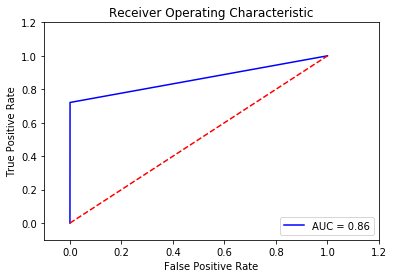

In [11]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/NN_oversample.png',bbox_inches="tight")

#### 3.3 不进行采样

In [12]:
model3 = Sequential()
model3.add(Dense(29, input_dim=29, activation='relu'))     # kernel_initializer='normal'
model3.add(Dense(100, input_dim=29, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))                 # kernel_initializer='normal'
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               3000      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 3,971
Trainable params: 3,971
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 未采样
model3.fit(X_train.as_matrix(),y_train.values.ravel(),epochs=1000)
y_pred = model3.predict(X_test.as_matrix()).astype(int)
y_test=np.array(y_test)

# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test,y_pred)
print("混淆矩阵：",cnf_matrix)
np.set_printoptions(precision=2)
print(classification_report(y_test,y_pred))
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ("AUC值：",roc_auc)

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch 1/1000
199364/199364 [==============================] - 10s 51us/step - loss: 0.0069 - accuracy: 0.9991
Epoch 2/1000
199364/199364 [==============================] - 9s 44us/step - loss: 0.0032 - accuracy: 0.9993
Epoch 3/1000
199364/199364 [==============================] - 10s 49us/step - loss: 0.0028 - accuracy: 0.9994
Epoch 4/1000
199364/199364 [==============================] - 9s 44us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 5/1000
199364/199364 [==============================] - 9s 47us/step - loss: 0.0024 - accuracy: 0.9994
Epoch 6/1000
199364/199364 [==============================] - 10s 50us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 7/1000
199364/199364 [==============================] - 12s 61us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 8/1000
199364/199364 [==============================] - 11s 55us/step - loss: 0.0021 - accuracy: 0.9995
Epoch 9/1000
199364/199364 [==============================] - 12s 60us/step - loss: 0.0020 - accuracy: 0.9995
Epoch 10/1000

Epoch 73/1000
199364/199364 [==============================] - 10s 48us/step - loss: 4.2475e-04 - accuracy: 0.9999
Epoch 74/1000
199364/199364 [==============================] - 13s 65us/step - loss: 5.1087e-04 - accuracy: 0.9998
Epoch 75/1000
199364/199364 [==============================] - 15s 76us/step - loss: 4.6842e-04 - accuracy: 0.9999
Epoch 76/1000
199364/199364 [==============================] - 10s 48us/step - loss: 4.4737e-04 - accuracy: 0.9999
Epoch 77/1000
199364/199364 [==============================] - 13s 63us/step - loss: 4.8396e-04 - accuracy: 0.9999
Epoch 78/1000
199364/199364 [==============================] - 14s 69us/step - loss: 4.3598e-04 - accuracy: 0.9999
Epoch 79/1000
199364/199364 [==============================] - 10s 52us/step - loss: 4.4445e-04 - accuracy: 0.9999
Epoch 80/1000
199364/199364 [==============================] - 9s 44us/step - loss: 5.5585e-04 - accuracy: 0.9998
Epoch 81/1000
199364/199364 [==============================] - 9s 45us/step - los

199364/199364 [==============================] - 9s 45us/step - loss: 3.3250e-04 - accuracy: 0.9999
Epoch 145/1000
199364/199364 [==============================] - 9s 43us/step - loss: 3.7240e-04 - accuracy: 0.9999
Epoch 146/1000
199364/199364 [==============================] - 9s 45us/step - loss: 2.6976e-04 - accuracy: 0.9999
Epoch 147/1000
199364/199364 [==============================] - 8s 41us/step - loss: 3.6836e-04 - accuracy: 0.9999
Epoch 148/1000
199364/199364 [==============================] - 9s 43us/step - loss: 3.3425e-04 - accuracy: 0.9999
Epoch 149/1000
199364/199364 [==============================] - 8s 40us/step - loss: 2.7033e-04 - accuracy: 0.9999
Epoch 150/1000
199364/199364 [==============================] - 8s 43us/step - loss: 5.1094e-04 - accuracy: 0.9999
Epoch 151/1000
199364/199364 [==============================] - 8s 41us/step - loss: 6.6960e-04 - accuracy: 0.9999
Epoch 152/1000
199364/199364 [==============================] - 9s 45us/step - loss: 2.7659e-04

199364/199364 [==============================] - 10s 51us/step - loss: 4.8201e-04 - accuracy: 1.0000
Epoch 215/1000
199364/199364 [==============================] - 15s 75us/step - loss: 2.2358e-04 - accuracy: 0.9999
Epoch 216/1000
199364/199364 [==============================] - 14s 70us/step - loss: 1.7702e-04 - accuracy: 0.9999
Epoch 217/1000
199364/199364 [==============================] - 10s 50us/step - loss: 2.2015e-04 - accuracy: 0.9999
Epoch 218/1000
199364/199364 [==============================] - 13s 66us/step - loss: 2.1120e-04 - accuracy: 0.9999
Epoch 219/1000
199364/199364 [==============================] - 8s 42us/step - loss: 1.7956e-04 - accuracy: 0.9999
Epoch 220/1000
199364/199364 [==============================] - 10s 48us/step - loss: 1.5497e-04 - accuracy: 1.0000
Epoch 221/1000
199364/199364 [==============================] - 9s 45us/step - loss: 1.5437e-04 - accuracy: 1.0000
Epoch 222/1000
199364/199364 [==============================] - 8s 42us/step - loss: 2.80

199364/199364 [==============================] - 10s 52us/step - loss: 1.0054e-04 - accuracy: 1.0000
Epoch 285/1000
199364/199364 [==============================] - 15s 76us/step - loss: 1.6986e-04 - accuracy: 1.0000
Epoch 286/1000
199364/199364 [==============================] - 11s 53us/step - loss: 3.7028e-04 - accuracy: 0.9999
Epoch 287/1000
199364/199364 [==============================] - 10s 50us/step - loss: 1.2529e-04 - accuracy: 1.0000
Epoch 288/1000
199364/199364 [==============================] - 11s 53us/step - loss: 2.8720e-04 - accuracy: 0.9999
Epoch 289/1000
199364/199364 [==============================] - 8s 42us/step - loss: 3.4314e-04 - accuracy: 0.9999
Epoch 290/1000
199364/199364 [==============================] - 11s 55us/step - loss: 2.1430e-04 - accuracy: 0.9999
Epoch 291/1000
199364/199364 [==============================] - 12s 59us/step - loss: 2.6865e-04 - accuracy: 0.9999
Epoch 292/1000
199364/199364 [==============================] - 9s 47us/step - loss: 2.2

199364/199364 [==============================] - 10s 50us/step - loss: 1.5900e-04 - accuracy: 1.0000
Epoch 356/1000
199364/199364 [==============================] - 9s 43us/step - loss: 1.5882e-04 - accuracy: 1.0000
Epoch 357/1000
199364/199364 [==============================] - 10s 49us/step - loss: 1.4643e-04 - accuracy: 1.0000
Epoch 358/1000
199364/199364 [==============================] - 10s 49us/step - loss: 1.7700e-04 - accuracy: 1.0000
Epoch 359/1000
199364/199364 [==============================] - 10s 49us/step - loss: 2.3812e-04 - accuracy: 1.0000
Epoch 360/1000
199364/199364 [==============================] - 10s 49us/step - loss: 2.6116e-04 - accuracy: 1.0000
Epoch 361/1000
199364/199364 [==============================] - 9s 43us/step - loss: 1.9333e-04 - accuracy: 0.9999
Epoch 362/1000
199364/199364 [==============================] - 9s 43us/step - loss: 2.6525e-04 - accuracy: 1.0000
Epoch 363/1000
199364/199364 [==============================] - 11s 56us/step - loss: 3.70

199364/199364 [==============================] - 10s 48us/step - loss: 2.4681e-04 - accuracy: 0.9999
Epoch 426/1000
199364/199364 [==============================] - 10s 52us/step - loss: 3.4972e-04 - accuracy: 0.9999
Epoch 427/1000
199364/199364 [==============================] - 11s 57us/step - loss: 5.4067e-05 - accuracy: 1.0000
Epoch 428/1000
199364/199364 [==============================] - 8s 42us/step - loss: 2.6915e-04 - accuracy: 1.0000
Epoch 429/1000
199364/199364 [==============================] - 8s 39us/step - loss: 4.3198e-04 - accuracy: 1.0000
Epoch 430/1000
199364/199364 [==============================] - 11s 55us/step - loss: 2.2353e-04 - accuracy: 1.0000
Epoch 431/1000
199364/199364 [==============================] - 9s 44us/step - loss: 1.1069e-04 - accuracy: 1.0000
Epoch 432/1000
199364/199364 [==============================] - 8s 38us/step - loss: 2.3223e-04 - accuracy: 0.9999
Epoch 433/1000
199364/199364 [==============================] - 9s 43us/step - loss: 1.7264

199364/199364 [==============================] - 7s 38us/step - loss: 1.0862e-04 - accuracy: 1.0000
Epoch 497/1000
199364/199364 [==============================] - 9s 45us/step - loss: 3.1261e-04 - accuracy: 1.0000
Epoch 498/1000
199364/199364 [==============================] - 13s 64us/step - loss: 3.9813e-04 - accuracy: 0.9999
Epoch 499/1000
199364/199364 [==============================] - 13s 64us/step - loss: 1.9027e-04 - accuracy: 0.9999
Epoch 500/1000
199364/199364 [==============================] - 13s 63us/step - loss: 1.7862e-04 - accuracy: 1.0000
Epoch 501/1000
199364/199364 [==============================] - 11s 55us/step - loss: 4.8158e-04 - accuracy: 1.0000
Epoch 502/1000
199364/199364 [==============================] - 9s 43us/step - loss: 2.8153e-04 - accuracy: 0.9999
Epoch 503/1000
199364/199364 [==============================] - 12s 58us/step - loss: 1.4702e-04 - accuracy: 1.00001s - ETA: 1s - loss: 1.611
Epoch 504/1000
199364/199364 [==============================] - 

199364/199364 [==============================] - 7s 34us/step - loss: 2.6034e-04 - accuracy: 1.0000
Epoch 567/1000
199364/199364 [==============================] - 6s 32us/step - loss: 4.2899e-04 - accuracy: 1.0000
Epoch 568/1000
199364/199364 [==============================] - 6s 32us/step - loss: 5.0655e-04 - accuracy: 0.9999
Epoch 569/1000
199364/199364 [==============================] - 7s 35us/step - loss: 2.8466e-04 - accuracy: 1.0000
Epoch 570/1000
199364/199364 [==============================] - 6s 32us/step - loss: 1.7082e-04 - accuracy: 1.0000
Epoch 571/1000
199364/199364 [==============================] - 7s 34us/step - loss: 4.5512e-04 - accuracy: 0.9999
Epoch 572/1000
199364/199364 [==============================] - 6s 32us/step - loss: 8.2725e-05 - accuracy: 1.0000
Epoch 573/1000
199364/199364 [==============================] - 7s 35us/step - loss: 2.2892e-04 - accuracy: 0.9999
Epoch 574/1000
199364/199364 [==============================] - 6s 32us/step - loss: 2.3471e-04

199364/199364 [==============================] - 6s 32us/step - loss: 9.0405e-05 - accuracy: 1.0000
Epoch 638/1000
199364/199364 [==============================] - 8s 41us/step - loss: 4.9840e-04 - accuracy: 1.0000
Epoch 639/1000
199364/199364 [==============================] - 6s 32us/step - loss: 3.4887e-04 - accuracy: 0.9999
Epoch 640/1000
199364/199364 [==============================] - 7s 34us/step - loss: 2.2580e-04 - accuracy: 1.0000
Epoch 641/1000
199364/199364 [==============================] - 6s 32us/step - loss: 8.1269e-05 - accuracy: 1.0000
Epoch 642/1000
199364/199364 [==============================] - 7s 33us/step - loss: 3.2476e-04 - accuracy: 0.9999
Epoch 643/1000
199364/199364 [==============================] - 7s 35us/step - loss: 8.4000e-05 - accuracy: 1.0000
Epoch 644/1000
199364/199364 [==============================] - 6s 32us/step - loss: 7.4726e-05 - accuracy: 1.0000
Epoch 645/1000
199364/199364 [==============================] - 7s 35us/step - loss: 1.4028e-04

199364/199364 [==============================] - 6s 32us/step - loss: 3.2145e-04 - accuracy: 0.9999
Epoch 709/1000
199364/199364 [==============================] - ETA: 0s - loss: 1.1299e-04 - accuracy: 1.00 - 6s 32us/step - loss: 1.1298e-04 - accuracy: 1.0000
Epoch 710/1000
199364/199364 [==============================] - 7s 34us/step - loss: 1.7605e-04 - accuracy: 0.9999
Epoch 711/1000
199364/199364 [==============================] - 6s 32us/step - loss: 3.4447e-04 - accuracy: 1.0000
Epoch 712/1000
199364/199364 [==============================] - 7s 34us/step - loss: 2.1581e-04 - accuracy: 1.0000
Epoch 713/1000
199364/199364 [==============================] - 6s 32us/step - loss: 2.5310e-04 - accuracy: 0.9999
Epoch 714/1000
199364/199364 [==============================] - 7s 33us/step - loss: 2.8426e-04 - accuracy: 1.0000
Epoch 715/1000
199364/199364 [==============================] - 7s 34us/step - loss: 2.2862e-04 - accuracy: 1.0000
Epoch 716/1000
199364/199364 [===================

Epoch 779/1000
199364/199364 [==============================] - 7s 34us/step - loss: 4.0282e-04 - accuracy: 0.9999
Epoch 780/1000
199364/199364 [==============================] - 7s 35us/step - loss: 3.7860e-04 - accuracy: 0.9999
Epoch 781/1000
199364/199364 [==============================] - 6s 32us/step - loss: 4.0607e-04 - accuracy: 1.0000
Epoch 782/1000
199364/199364 [==============================] - 6s 32us/step - loss: 7.1298e-05 - accuracy: 1.0000
Epoch 783/1000
199364/199364 [==============================] - 7s 36us/step - loss: 3.7647e-04 - accuracy: 0.9999
Epoch 784/1000
199364/199364 [==============================] - 6s 32us/step - loss: 3.3968e-04 - accuracy: 0.9999
Epoch 785/1000
199364/199364 [==============================] - 7s 34us/step - loss: 1.1520e-04 - accuracy: 1.0000
Epoch 786/1000
199364/199364 [==============================] - 6s 32us/step - loss: 2.0971e-04 - accuracy: 1.0000
Epoch 787/1000
199364/199364 [==============================] - 7s 33us/step - l

199364/199364 [==============================] - 7s 34us/step - loss: 1.1540e-04 - accuracy: 1.0000
Epoch 851/1000
199364/199364 [==============================] - 6s 31us/step - loss: 3.2419e-04 - accuracy: 0.9999
Epoch 852/1000
199364/199364 [==============================] - 6s 32us/step - loss: 1.0357e-04 - accuracy: 1.0000
Epoch 853/1000
199364/199364 [==============================] - 7s 34us/step - loss: 4.6186e-04 - accuracy: 0.9999
Epoch 854/1000
199364/199364 [==============================] - 7s 33us/step - loss: 2.0633e-04 - accuracy: 1.0000
Epoch 855/1000
199364/199364 [==============================] - 7s 34us/step - loss: 1.6635e-04 - accuracy: 0.9999
Epoch 856/1000
199364/199364 [==============================] - 6s 32us/step - loss: 1.2031e-04 - accuracy: 1.0000
Epoch 857/1000
199364/199364 [==============================] - 6s 32us/step - loss: 6.6736e-04 - accuracy: 1.0000
Epoch 858/1000
199364/199364 [==============================] - 7s 34us/step - loss: 3.6937e-04

199364/199364 [==============================] - 7s 34us/step - loss: 9.6791e-05 - accuracy: 1.0000
Epoch 922/1000
199364/199364 [==============================] - 7s 33us/step - loss: 1.5234e-04 - accuracy: 1.0000
Epoch 923/1000
199364/199364 [==============================] - 7s 34us/step - loss: 3.6129e-04 - accuracy: 0.9999
Epoch 924/1000
199364/199364 [==============================] - 6s 32us/step - loss: 2.9315e-04 - accuracy: 1.0000
Epoch 925/1000
199364/199364 [==============================] - 6s 32us/step - loss: 1.1566e-04 - accuracy: 1.0000
Epoch 926/1000
199364/199364 [==============================] - 7s 35us/step - loss: 1.6589e-04 - accuracy: 1.0000
Epoch 927/1000
199364/199364 [==============================] - 6s 32us/step - loss: 9.9856e-05 - accuracy: 1.0000
Epoch 928/1000
199364/199364 [==============================] - 7s 34us/step - loss: 1.7341e-04 - accuracy: 1.0000
Epoch 929/1000
199364/199364 [==============================] - 7s 33us/step - loss: 2.5959e-05

199364/199364 [==============================] - 6s 32us/step - loss: 8.5458e-04 - accuracy: 0.9999
Epoch 993/1000
199364/199364 [==============================] - 7s 33us/step - loss: 1.0450e-04 - accuracy: 1.0000
Epoch 994/1000
199364/199364 [==============================] - 7s 35us/step - loss: 1.4010e-04 - accuracy: 1.0000
Epoch 995/1000
199364/199364 [==============================] - 6s 32us/step - loss: 2.5201e-04 - accuracy: 1.0000
Epoch 996/1000
199364/199364 [==============================] - 7s 35us/step - loss: 1.6610e-04 - accuracy: 1.0000
Epoch 997/1000
199364/199364 [==============================] - 6s 32us/step - loss: 1.5060e-04 - accuracy: 1.0000
Epoch 998/1000
199364/199364 [==============================] - 7s 35us/step - loss: 5.7751e-05 - accuracy: 1.0000
Epoch 999/1000
199364/199364 [==============================] - 7s 34us/step - loss: 1.5498e-04 - accuracy: 1.0000
Epoch 1000/1000
199364/199364 [==============================] - 6s 32us/step - loss: 4.9211e-0

E:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


混淆矩阵： [[85236    60]
 [   38   109]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.64      0.74      0.69       147

    accuracy                           1.00     85443
   macro avg       0.82      0.87      0.84     85443
weighted avg       1.00      1.00      1.00     85443

测试集Recall:  0.7414965986394558
AUC值： 0.8703965829438135


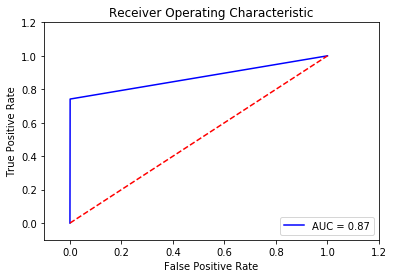

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./result_img/NN_without_sample.png',bbox_inches="tight")